This code is based on this python wave function implementation: https://github.com/ikarth/wfc_python 
The code was cleaned and simplified. New patterns and imput images were provided (taken from here:https://github.com/mxgmn/WaveFunctionCollapse). Additionally, a gif tracing the process has been created. 

In [37]:
#Change image folder if needed
Path = "/content"

In [15]:
# -*- coding: utf-8 -*-

# 
# The MIT License(MIT)
# Copyright Isaac Karth 2017
# Based on WaveFunctionCollapse in C#, which is Copyright(c) mxgmn 2016.
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# The software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose and noninfringement. In no event shall the authors or copyright holders be liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, arising from, out of or in connection with the software or the use or other dealings in the software.
#
import base64
import math
import random
import collections
import io
from PIL import Image
from IPython import display



In [38]:
#Overlapping model class
class OverlappingModel():
        
    def __init__(self, width, height, name, N_value = 2, periodic_input_value = True, periodic_output_value = False, symmetry_value = 8, ground_value = 0):
        """
        Initializes the model.
        """
        self.propagator = [[[[]]]]
        self.N = N_value
        self.periodic = periodic_output_value
        self.bitmap = Image.open("{0}/{1}.png".format(Path,name))
        self.SMX = self.bitmap.size[0]
        self.SMY = self.bitmap.size[1]

        self.stationary = []
        self.FMX = width
        self.FMY = height
        self.T = 2       
        self.rng = random.Random()
        self.wave = [[[False for _ in range(self.T)] for _ in range(self.FMY)] for _ in range(self.FMX)]
        self.changes = [[False for _ in range(self.FMY)] for _ in range(self.FMX)]
        self.observed = None
        self.images= []
        self.log_prob = 0
        self.log_t = math.log(self.T)  
        self.observe_count = 0      
        self.count_prop_passes = 0
       
        
        # .sample is an array of arrays that holds the index values for colors 
        # as found in the source image
        self.sample = [[0 for _ in range(self.SMY)] for _ in range(self.SMX)]
        # .colors is the list of colors that are found in the source image
        self.colors = []
        
        # This initializes the .sample array with the color index values.
        # It loops over the pixels in the source bitmap, adds the color to the
        # list of colors if it is new, and sets the .sample x,y value to the
        # index of the color in the list of colors.
        for y in range(0, self.SMY):
            for x in range(0, self.SMX):
                a_color = self.bitmap.getpixel((x, y))
                color_exists = [c for c in self.colors if c == a_color]
                if len(color_exists) < 1:
                    self.colors.append(a_color)
                samp_result = [i for i,v in enumerate(self.colors) if v == a_color]
                self.sample[x][y] = samp_result
                
        self.color_count = len(self.colors)
        self.W = GetPower(self.color_count, self.N * self.N)
        
        # The pattern matrix, as an array of arrays.
        self.patterns= [[]]
        
        # A helper function to extract the neighboring cells from the sample
        # matrix. Takes a function that translates (dx,dy) into a reference to a cell in the matrix.
        def FuncPattern(passed_func):
            result = [0 for _ in range(self.N * self.N)]
            for y in range(0, self.N):
                for x in range(0, self.N):
                    result[x + (y * self.N)] = passed_func(x, y)
            return result
            
        pattern_func = FuncPattern
            
        def PatternFromSample(x, y):
            '''
            Takes the sample and returns the pattern for that (x,y) location.
            '''
            def innerPattern(dx, dy):
                return self.sample[(x + dx) % self.SMX][(y + dy) % self.SMY]
            return pattern_func(innerPattern)

        def Rotate(p):
            '''
            Returns a rotated version of the pattern.
            '''
            return FuncPattern(lambda x, y: p[self.N - 1 - y + x * self.N])

        def Reflect(p):
            '''
            Returns a reflected version of the pattern.
            '''
            return FuncPattern(lambda x, y: p[self.N - 1 - x + y * self.N])
            
        def Index(p):
            '''
            Converts a color index into a powers-of-two representation for
            bytewise storage.
            '''
            result = 0
            power = 1
            for i in range(0, len(p)):
                result = result + (sum(p[len(p) - 1 - i]) * power)
                power = power * self.color_count
            return result

                                    
        def PatternFromIndex(ind):
            '''
            Takes a pattern index and returns the pattern byte power index.
            '''
            residue = ind
            power = self.W
            result = [None for _ in range(self.N * self.N)]
            for i in range(0, len(result)):
                power = power / self.color_count
                count = 0
                while residue >= power:
                    residue = residue - power
                    count = count + 1
                result[i] = count
            return result
            
        self.weights = collections.Counter()
        ordering = []
        
        # This chunk converts the sample to patterns.
        # if periodic_input_value is true, the source image wraps around 
        ylimit = self.SMY - self.N + 1
        xlimit = self.SMX - self.N + 1
        if True == periodic_input_value:
            ylimit = self.SMY
            xlimit = self.SMX
        for y in range (0, ylimit):
            for x in range(0, xlimit):
                ps = [0 for _ in range(8)]
                ps[0] = PatternFromSample(x,y)
                ps[1] = Reflect(ps[0])
                ps[2] = Rotate(ps[0])
                ps[3] = Reflect(ps[2])
                ps[4] = Rotate(ps[2])
                ps[5] = Reflect(ps[4])
                ps[6] = Rotate(ps[4])
                ps[7] = Reflect(ps[6])
                for k in range(0,symmetry_value):
                    ind = Index(ps[k])
                    indexed_weight = collections.Counter({ind : 1})
                    self.weights = self.weights + indexed_weight
                    if not ind in ordering:
                        ordering.append(ind)
                        
        self.T = len(self.weights)
        self.ground = int((ground_value + self.T) % self.T)
        
        self.patterns = [[None] for _ in range(self.T)]
        self.stationary = [None for _ in range(self.T)]
        self.propagator = [[[[0]]] for _ in range(2 * self.N - 1)]
        
        counter = 0
        for w in ordering:
            self.patterns[counter] = PatternFromIndex(w)
            self.stationary[counter] = self.weights[w]
            counter += 1
            
        for x in range(0, self.FMX):
            for y in range(0, self.FMY):
                self.wave[x][y] = [False for _ in range(self.T)]
                
        def Agrees(p1, p2, dx, dy):
            ifany = True
            xmin = dx
            xmax = self.N
            if dx < 0:
                xmin = 0
                xmax = dx + self.N
            ymin = dy
            ymax = self.N
            if dy < 0:
                ymin = 0
                ymax = dy + self.N
            for y in range(ymin, ymax):
                for x in range(xmin, xmax):
                    if p1[x + self.N * y] != p2[x - dx + self.N * (y - dy)]:
                        ifany = False
            return ifany

        for x in range(0, 2 * self.N - 1):
            self.propagator[x] = [[[0]] for _ in range(2 * self.N - 1)]
            for y in range(0, 2 * self.N - 1):
                self.propagator[x][y] = [[0] for _ in range(self.T)]
                for t in range(0, self.T):
                    a_list = []
                    for t2 in range(0, self.T):
                        if Agrees(self.patterns[t], self.patterns[t2], x - self.N + 1, y - self.N + 1):
                            a_list.append(t2)
                    self.propagator[x][y][t] = [0 for _ in range(len(a_list))]
                    for c in range(0, len(a_list)):
                        self.propagator[x][y][t][c] = a_list[c]
        return
                    
    def OnBoundary(self, x, y):
        return (not self.periodic) and ((x + self.N > self.FMX ) or (y + self.N > self.FMY))

    def Observe(self):

        self.observe_count += 1
        observed_min = 1e+3
        observed_sum = 0
        main_sum = 0
        log_sum = 0
        noise = 0
        entropy = 0      
        argminx = -1
        argminy = -1
        amount = None
        w = []
        
        # Find the point of minimum entropy
        for x in range(0, self.FMX):
            for y in range(0, self.FMY):
                if self.OnBoundary(x, y):
                    pass
                else:
                    w = self.wave[x][y]
                    amount = 0
                    observed_sum = 0
                    t = 0
                    while t < self.T:
                        if w[t]:
                            amount += 1
                            observed_sum += self.stationary[t]
                        t += 1
                    if 0 == observed_sum:
                        return False
                    noise = 1e-6 * self.rng.random()
                    if 1 == amount:
                        entropy = 0
                    elif self.T == amount:
                        entropy = self.log_t
                    else:
                        main_sum = 0
                        log_sum = math.log(observed_sum)
                        t = 0
                        while t < self.T:
                            if w[t]:
                                main_sum += self.stationary[t] * self.log_prob[t]
                            t += 1
                        entropy = log_sum - main_sum / observed_sum
                    if entropy > 0 and (entropy + noise < observed_min):
                        observed_min = entropy + noise
                        argminx = x
                        argminy = y
                    
        # No minimum entropy, so mark everything as being observed...
        if (-1 == argminx) and (-1 == argminy):
            self.observed = [[0 for _ in range(self.FMY)] for _ in range(self.FMX)]
            for x in range(0, self.FMX):
                self.observed[x] = [0 for _ in range(self.FMY)]
                for y in range(0, self.FMY):
                    for t in range(0, self.T):
                        if self.wave[x][y][t]:
                            self.observed[x][y] = t
                            break
            return True
          
        # A minimum point has been found, so prep it for propogation...
        distribution = [0 for _ in range(0,self.T)]
        for t in range(0,self.T):
            distribution[t] = self.stationary[t] if self.wave[argminx][argminy][t] else 0
        r = GetRandom(distribution, self.rng.random())
        for t in range(0,self.T):
            self.wave[argminx][argminy][t] = (t == r)
        self.changes[argminx][argminy] = True
        return None
    
    def Propagate(self):
        change = False
        b = False
        

        for x1 in range(0, self.FMX):
            for y1 in range(0, self.FMY):
                if (self.changes[x1][y1]):
                    self.changes[x1][y1] = False
                    dx = (0 - self.N) + 1
                    while dx < self.N:
                    #for dx in range(1 - self.N, self.N):
                        dy = (0 - self.N) + 1
                        while dy < self.N:
                        #for dy in range(1 - self.N, self.N):
                            x2 = x1 + dx
                            if x2 < 0:
                                x2 += self.FMX
                            elif x2 >= self.FMX:
                                    x2 -= self.FMX
                            y2 = y1 + dy
                            if y2 < 0:
                                y2 += self.FMY
                            elif y2 >= self.FMY:
                                    y2 -= self.FMY
                                    
                            if (not self.periodic) and (x2 + self.N > self.FMX or y2 + self.N > self.FMY):
                                pass
                            else:
                            
                                w1 = self.wave[x1][y1]
                                w2 = self.wave[x2][y2]
                                
                                p = self.propagator[(self.N - 1) - dx][(self.N - 1) - dy]
                                
                                for t2 in range(0,self.T):
                                    if (not w2[t2]):
                                        pass
                                    else:
                                        b = False
                                        prop = p[t2]
                                        i_one = 0
                                        while (i_one < len(prop)) and (False == b):
                                            b = w1[prop[i_one]]
                                            i_one += 1                                    
                                        if False == b:
                                            self.changes[x2][y2] = True
                                            change = True
                                            w2[t2] = False
                            dy += 1
                        dx += 1                                
        return change


    def Run(self, seed, limit = 0):
        self.log_t = math.log(self.T)
        self.log_prob = [0 for _ in range(self.T)]
        for t in range(0,self.T):
            self.log_prob[t] = math.log(self.stationary[t])
        self.Clear()
        self.rng = random.Random()
        self.rng.seed(seed)
        l = 0
        while (l < limit) or (0 == limit): # if limit == 0, then don't stop
            l += 1
            result = self.Observe()
            if None != result:
                return result
            pcount = 0
            presult = True
            while(presult):
                presult = self.Propagate()
                self.images.append(self.Graphics())
                pcount += 1
        
    def Graphics(self):
        result = Image.new("RGB",(self.FMX, self.FMY),(0,0,0))
        bitmap_data = list(result.getdata())
        if(self.observed != None):
            for y in range(0, self.FMY):
                dy = self.N - 1
                if (y < (self.FMY - self.N + 1)):
                    dy = 0
                for x in range(0, self.FMX):
                    dx = 0
                    if (x < (self.FMX - self.N + 1)):
                        dx = self.N - 1
                    local_obsv = self.observed[x - dx][y - dy]
                    local_patt = self.patterns[local_obsv][dx + dy * self.N]
                    c = self.colors[local_patt]
                    if isinstance(c, (int, float)):
                        bitmap_data[x + y * self.FMX] = (c, c, c)
                    else:
                        bitmap_data[x + y * self.FMX] = (c[0], c[1], c[2])
                    
        else:
            for y in range(0, self.FMY):
                for x in range(0, self.FMX):
                    contributors = 0
                    r = 0
                    g = 0
                    b = 0
                    for dy in range(0, self.N):
                        for dx in range(0, self.N):
                            sx = x - dx
                            if sx < 0:
                                sx += self.FMX
                            sy = y - dy
                            if sy < 0:
                                sy += self.FMY
                            if (self.OnBoundary(sx, sy)):
                                pass
                            else:
                                for t in range(0, self.T):
                                    if self.wave[sx][sy][t]:
                                        contributors += 1
                                        color = self.colors[self.patterns[t][dx + dy * self.N]]
                                        if isinstance(color, (int, float)):
                                            r = int(color)
                                            g = int(color)
                                            b = int(color)
                                        else:
                                            r += int(color[0])#.R
                                            g += int(color[1])#.G
                                            b += int(color[2])#.B
                    if contributors > 0:
                        bitmap_data[x + y * self.FMX] = (int(r / contributors), int(g / contributors), int(b / contributors))
                    else:
                        print("WARNING: No contributors")
                        bitmap_data[x + y * self.FMX] = (int(r), int(g), int(b))
        result.putdata(bitmap_data)
        return result
        
    def Clear(self):

        for x in range(0,self.FMX):
            for y in range(0, self.FMY):
                for t in range(0, self.T):
                    self.wave[x][y][t] = True
                self.changes[x][y] = False

        if(self.ground != 0 ):
           
            for x in range(0, self.FMX):
                for t in range(0, self.T):
                    if t != self.ground:
                        self.wave[x][self.FMY - 1][t] = False
                    self.changes[x][self.FMY - 1] = True
                    
                    for y in range(0, self.FMY - 1):
                        self.wave[x][y][self.ground] = False
                        self.changes[x][y] = True
            while self.Propagate():
                pass           

In [5]:
# help functions 
def GetRandom(source_array, random_value):
    a_sum = sum(source_array)
    
    if 0 == a_sum:
        for j in range(0, len(source_array)):
            source_array[j] = 1
        a_sum = sum(source_array)
    for j in range(0, len(source_array)):
        source_array[j] /= a_sum
    i = 0
    x = 0
    while (i < len(source_array)):
        x += source_array[i]
        if random_value <= x:
            return i
        i += 1
    return 0
    
def GetPower(a, n):
    product = 1
    for i in range(0, n):
        product *= a
    return product
    

Examples 

In [30]:
  # Run
  a_model = OverlappingModel(20, 20, "Flowers") # length of output, input image
  a_model.Run(random.Random()) # seed 

  # Display
  out = io.BytesIO()
  a_model.images[0].save(out, format='gif', save_all=True, append_images=a_model.images[1:],
                duration=50, loop=0)
  display.display(a_model.Graphics())
  display.HTML('<img src="data:image/gif;base64,{0}">'
              .format(base64.b64encode(out.getvalue()).decode('utf8')))

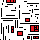


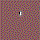

In [34]:
# Run
a_model = OverlappingModel(40, 40, "City") # length of output, input image
a_model.Run(random.Random()) # seed 

# Display
out = io.BytesIO()
a_model.images[0].save(out, format='gif', save_all=True, append_images=a_model.images[1:],
                duration=50, loop=0)
display.display(a_model.Graphics())
display.HTML('<img src="data:image/gif;base64,{0}">'
              .format(base64.b64encode(out.getvalue()).decode('utf8')))


In [39]:
# Run
a_model = OverlappingModel(20, 20, "Skyline2") # length of output, input image
a_model.Run(random.Random()) # seed 

# Display
out = io.BytesIO()
a_model.images[0].save(out, format='gif', save_all=True, append_images=a_model.images[1:],
                duration=50, loop=0)
display.display(a_model.Graphics())
display.HTML('<img src="data:image/gif;base64,{0}">'
              .format(base64.b64encode(out.getvalue()).decode('utf8')))

In [33]:
# Run
a_model = OverlappingModel(20, 20, "Knot") # length of output, input image
a_model.Run(random.Random()) # seed 

# Display
out = io.BytesIO()
a_model.images[0].save(out, format='gif', save_all=True, append_images=a_model.images[1:],
                duration=50, loop=0)
display.display(a_model.Graphics())
display.HTML('<img src="data:image/gif;base64,{0}">'
              .format(base64.b64encode(out.getvalue()).decode('utf8')))

In [36]:
# Run
a_model = OverlappingModel(20, 20, "Sewers") # length of output, input image
a_model.Run(random.Random()) # seed 

# Display
out = io.BytesIO()
a_model.images[0].save(out, format='gif', save_all=True, append_images=a_model.images[1:],
                duration=50, loop=0)
display.display(a_model.Graphics())
display.HTML('<img src="data:image/gif;base64,{0}">'
              .format(base64.b64encode(out.getvalue()).decode('utf8')))